In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from scipy import stats

sns.set(style="darkgrid")

In [148]:
# считываем данные из файлов
data = pd.read_csv('lipid_data.csv', low_memory=False, index_col='m/z')
metadata = pd.read_csv('metadata.csv', index_col='Name')
metadata.fillna(value={'Vitamin D intake' : 'no', 'Weight (mg)' : 1}, inplace=True)

In [149]:
Ret_time, Adducts = data['Retention time (min)'], data['Adducts'] # тоже нужно как-то использовать

In [150]:
# оставим только актуальные измерения

for name in metadata.index:
    finds = []
    ms = re.search(r'MS.+?_', name).group()
    for i in data.columns:
        if re.search(ms, i):
            finds.append(i)
    if len(finds):
        finds.sort(key=lambda x: len(x)) # альтернативно -len(x)
        data[name] = data[finds[-1]]
#         print(name)
#         print(finds[-1])
#         print()
        for col in finds:
            if col != name:
                del data[col]
    else:
        print('Attention!  ', name)

In [151]:
# сортируем строки по значению m/z (иаче как-то странно)
data.sort_index(inplace=True) # почему-то теряются значения колонки 'Adducts'
del data['Adducts'] # значит не так уж она и нужна!

### Фильтрация

In [152]:
blank_ind = np.vectorize(re.search)(r'[Bb]lank', data.columns) != None # индексы бланков
blanc_acc = data[data.columns[blank_ind]].apply(np.max, axis=1) # собирательный образ бланка
for col in data.columns[blank_ind]: # бланки больше не нужны
    del data[col]
data['blanc_acc'] = blanc_acc

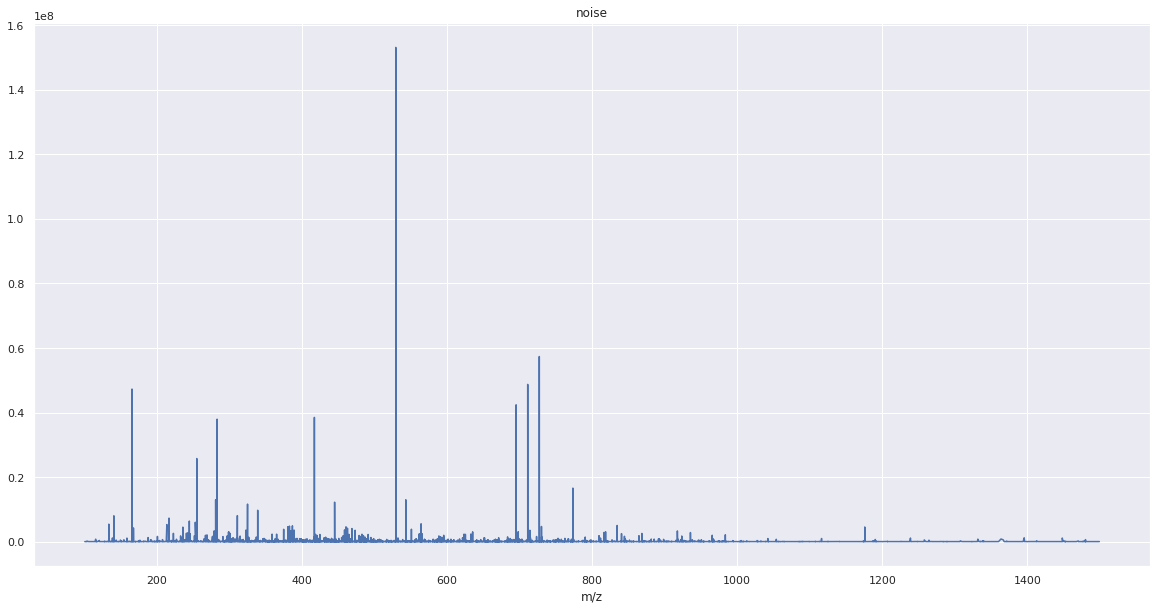

In [159]:
g = data['blanc_acc'].plot(title='noise', figsize=(20,10))

Фильтрация вычитанием

In [25]:
# по возможности вычитаем из пиков значения в собирательном бланке для данного m/z

for col in data.columns[1:-1]:
    data[col] -= data['blanc_acc']
    data[col][data[col] < 0] = 0
    
del data['blanc_acc']

Фильтрация по пороговому значению

In [ ]:
# удаляем пик, если он менее чем в C раз больше значения в собирательном бланке для данного m/z

C = 10
for col in data.columns[1:-1]:
    data[col][data[col] < data['blanc_acc']*C] = 0
    
del data['blanc_acc']

Жесткая фильтрация (думаю, так не нужно)

In [ ]:
# удаляем пик, если значение в собирательном бланке для данного m/z больше нуля

for col in data.columns[1:-1]:
    data[col][data['blanc_acc'] > 0] = 0
    
del data['blanc_acc']

### Нормализация

In [88]:
dta = data.copy()

In [194]:
# нормируем делением на массу пробы
#data_T.iloc[:, 3:] = data_T.iloc[:, 3:].T.transform(lambda x: x/x[0]).T

In [ ]:
#del data_T['Weight (mg)'] # больше не нужно

In [89]:
# нормируем образцы на суммарный ток

for name in dta.columns[:]:
    dta[name] /= dta[name].sum()

In [15]:
# ЧТО С ЭТИМ ДЕЛАТЬ ???

c = 1
for col in data.columns:
    srch = 0
    for name in metadata.index:
        ms = re.search(r'MS.+?_', name).group()
        if re.search(ms, col):
            srch = 1
    if not srch:
        print(c, col)
        c += 1

1 Retention time (min)
2 2018-06-07_rats_QC-8_liver_neg
3 2018-06-07_rats_QC-9_liver_neg
4 2018-06-07_rats_QC-last_liver_neg
5 2018-06-07_rats_QC-1_brain_neg
6 2018-06-07_rats_QC-2_brain_neg
7 2018-06-07_rats_QC-3_brain_neg
8 2018-06-07_rats_QC-last_brain_neg
9 2018-06-07_rats_QC-6_plasma_neg
10 2018-06-07_rats_QC-7_plasma_neg
11 2018-06-07_rats_QC-last_plasma_neg
12 2018-06-07_rats_QC-4_muscle_neg
13 2018-06-07_rats_QC-5_muscle_neg
14 2018-06-07_rats_QC-last_muscle_neg
15 2018-06-07_rats_MS94_Liver_neg.1
16 2018-06-07_rats_QC-8_liver_neg.1
17 2018-06-07_rats_QC-9_liver_neg.1
18 2018-06-07_rats_QC-last_liver_neg.1
19 2018-06-07_rats_MS10_Brain(CB)_neg.1
20 2018-06-07_rats_MS33_Brain(PFC)_neg.1
21 2018-06-07_rats_MS34_Brain(PFC)_neg.1
22 2018-06-07_rats_QC-1_brain_neg.1
23 2018-06-07_rats_QC-2_brain_neg.1
24 2018-06-07_rats_QC-3_brain_neg.1
25 2018-06-07_rats_QC-last_brain_neg.1
26 2018-06-07_rats_MS66_Plasma_neg.1
27 2018-06-07_rats_QC-6_plasma_neg.1
28 2018-06-07_rats_QC-7_plasma_neg.

In [90]:
md = metadata.loc[metadata['comment'] != 'x'][['Tissue', 'Age', 'Vitamin D intake']] #, 'Weight (mg)']]

In [91]:
# мерджим по индексам колонки с инфой
data_T = pd.merge(md, dta.T, left_index=True, right_index=True)

In [102]:
data_T = data_T.loc[:, data_T.sum() != 0] # уберем пкстые m/z

In [110]:
# липиды, значимо отличающиеся между тканями

Tis = set(data_T['Tissue'])

MZ = []
for mz in data_T.columns[3:]:
    T = []
    for t in Tis:
        T.append(data_T[data_T['Tissue'] == t][mz])
    if stats.f_oneway(*T)[1] < 0.05:
        MZ.append(mz)

In [139]:
# трехкратный пермутационный тест

MZ_1 = []
for mz in MZ:
    T = []
    for t in Tis:
        T.append(data_T[np.random.permutation(data_T['Tissue']) == t][mz])
    if stats.f_oneway(*T)[1] < 0.05:
        MZ_1.append(mz)
        
MZ_2 = []
for mz in MZ_1:
    T = []
    for t in Tis:
        T.append(data_T[np.random.permutation(data_T['Tissue']) == t][mz])
    if stats.f_oneway(*T)[1] < 0.05:
        MZ_2.append(mz)
        
MZ_3 = []
for mz in MZ_2:
    T = []
    for t in Tis:
        T.append(data_T[np.random.permutation(data_T['Tissue']) == t][mz])
    if stats.f_oneway(*T)[1] < 0.05:
        MZ_3.append(mz)
        
len(MZ_3) # если 0, то все норм

/home/hamit/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


0

In [143]:
MZ_p = ['Tissue', 'Age', 'Vitamin D intake']
MZ_p.extend(MZ)

In [146]:
data_T = data_T[MZ_p]

In [171]:
# метрика по N наиболее значимым пикам
N = 100
P = {}
print('Tissue\t\told - old+D\tyoung - old+D\tyoung - old\n')
for tissue in set(md['Tissue']): # три группы на одном графике по тканям
    vitamin = group_data[tissue]['old']['yes']
    old_control = group_data[tissue]['old']['no']
    young_control = group_data[tissue]['young']['no']
    
    ind = np.maximum(np.maximum(vitamin, old_control), young_control).sort_values(ascending=False).head(N).index
    
    v_o = np.sum(np.abs(vitamin.loc[ind] - old_control.loc[ind])**2)
    v_y = np.sum(np.abs(vitamin.loc[ind] - young_control.loc[ind])**2)
    y_o = np.sum(np.abs(old_control.loc[ind] - young_control.loc[ind])**2)
    
    print(tissue, '  \t  {:.5f}'.format(v_o), '\t   {:.5f}'.format(v_y),'\t   {:.5f}'.format(y_o))
    
    # ANOVA
    ind = ['Tissue', 'Age', 'Vitamin D intake'] + list(ind)
    cols = data_T[ind].columns[3:]
    
    yng_ind = (data_T[ind]['Age'] == 'young') & (data_T[ind]['Vitamin D intake'] == 'no')
    old_ind = (data_T[ind]['Age'] == 'old') & (data_T[ind]['Vitamin D intake'] == 'no')
    vit_ind = (data_T[ind]['Age'] == 'old') & (data_T[ind]['Vitamin D intake'] == 'yes')
    
    tis = data_T[ind][data_T['Tissue'] == tissue]
    P[tissue] = []
    for col in cols:
        p_yo = stats.f_oneway(tis.loc[yng_ind][col], tis.loc[old_ind][col])[1]
        p_vy = stats.f_oneway(tis.loc[yng_ind][col], tis.loc[vit_ind][col])[1]
        p_vo = stats.f_oneway(tis.loc[old_ind][col], tis.loc[vit_ind][col])[1]
        if p_yo < 0.05 and (p_vo < 0.05 or p_vy < 0.05):
            P[tissue].append((col, p_vy, p_vo))

Tissue		old - old+D	young - old+D	young - old

plasma   	  0.00126 	   0.00140 	   0.00105
Brain (PFC)   	  0.00128 	   0.00382 	   0.00714
Liver   	  0.00595 	   0.00773 	   0.00276
Brain (CB)   	  0.00120 	   0.00859 	   0.00776
Muscle   	  0.02044 	   0.00353 	   0.00974


In [176]:
for tis in P:
    print(tis)
    for mz in P[tis]:
        print('\t{:.10f}\t'.format(mz[0]), ':\tp_vy = {:.3f};'.format(mz[1]), '\tp_vo = {:.3f};'.format(mz[2]))

plasma
Brain (PFC)
Liver
Brain (CB)
Muscle
	872.6360676113	 :	p_vy = 0.309; 	p_vo = 0.003;
	1469.9420143476	 :	p_vy = 0.460; 	p_vo = 0.012;


In [122]:
a = np.arange(10)
np.random.permutation(a)

array([8, 4, 3, 0, 5, 9, 6, 2, 1, 7])

In [160]:
group_data = data_T.groupby(['Tissue', 'Age', 'Vitamin D intake']).sum().T # группируем

нормализация на "суммарный ток" для каждого образца

In [161]:
group_data = group_data.transform(lambda x: x/x.sum())

нормализация на единицу внутри каждой ткани

In [62]:
for tissue in set(md['Tissue']):
    group_data[tissue] /= group_data[tissue].max().max()

In [199]:
#data_T.to_csv('group_data.csv') # сохраняем в файл

Liver


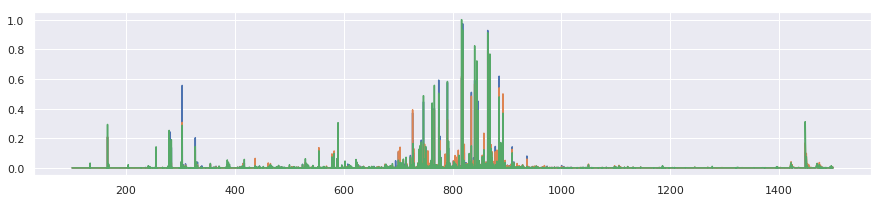

Muscle


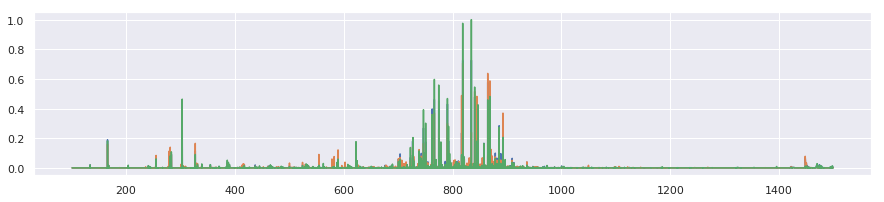

plasma


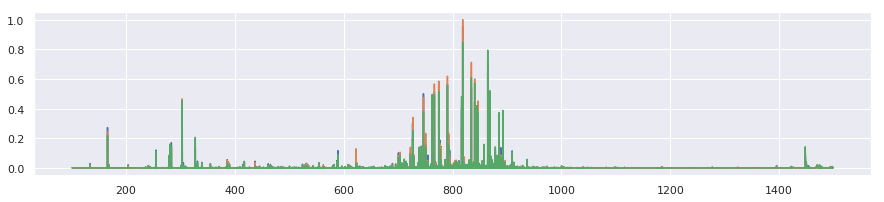

Brain (PFC)


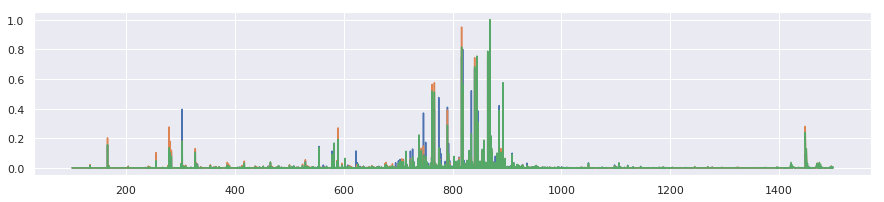

Brain (CB)


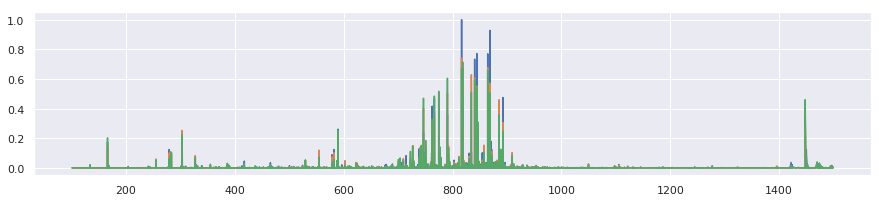

In [27]:
for tissue in set(md['Tissue']): # три группы на одном графике по тканям
    print(tissue)
    group_data[tissue]['young']['no'].plot(figsize=(15,3))
    group_data[tissue]['old']['no'].plot(figsize=(15,3))
    group_data[tissue]['old']['yes'].plot(figsize=(15,3))
    plt.show()

Отличий в локализации пиков не видно ни для одной из тканей, попробуем оценить интенсивность. В качестве метрики выберем норму разности группы старых мышей с витамином и двух контрольных.

In [28]:
print('Tissue\t\told - old+D\tyoung - old+D\tyoung - old\n')
for tissue in set(md['Tissue']): # три группы на одном графике по тканям
    vitamin = group_data[tissue]['old']['yes']
    old_control = group_data[tissue]['old']['no']
    young_control = group_data[tissue]['young']['no']
    v_o = np.sum(np.abs(vitamin - old_control)**2)
    v_y = np.sum(np.abs(vitamin - young_control)**2)
    y_o = np.sum(np.abs(old_control - young_control)**2)
    print(tissue, '  \t  {:.3f}'.format(v_o), '\t   {:.3f}'.format(v_y),'\t   {:.3f}'.format(y_o))

Tissue		old - old+D	young - old+D	young - old

Liver   	  1.167 	   0.987 	   0.619
Muscle   	  1.514 	   0.423 	   0.539
plasma   	  0.235 	   0.239 	   0.164
Brain (PFC)   	  0.166 	   0.751 	   1.005
Brain (CB)   	  0.151 	   0.986 	   0.874


In [29]:
# вариант подсчета метрики с пороговым значением
edge = 0.1
print('Tissue\t\told - old+D\tyoung - old+D\tyoung - old\n')
for tissue in set(md['Tissue']): # три группы на одном графике по тканям
    vitamin = group_data[tissue]['old']['yes']
    old_control = group_data[tissue]['old']['no']
    young_control = group_data[tissue]['young']['no']
    
    ind_vo = (vitamin > edge) | (old_control > edge)
    v_o = np.sum(np.abs(vitamin[ind_vo] - old_control[ind_vo])**2)
    
    ind_vy = (vitamin > edge) | (young_control > edge)
    v_y = np.sum(np.abs(vitamin[ind_vy] - young_control[ind_vy])**2)
    
    ind_yo = (vitamin > edge) | (young_control > edge)
    y_o = np.sum(np.abs(old_control[ind_yo] - young_control[ind_yo])**2)
    
    print(tissue, '  \t  {:.3f}'.format(v_o), '\t   {:.3f}'.format(v_y),'\t   {:.3f}'.format(y_o))

Tissue		old - old+D	young - old+D	young - old

Liver   	  1.077 	   0.904 	   0.562
Muscle   	  1.406 	   0.369 	   0.468
plasma   	  0.203 	   0.198 	   0.141
Brain (PFC)   	  0.140 	   0.693 	   0.929
Brain (CB)   	  0.135 	   0.941 	   0.824


In [30]:
# метрика по N наиболее значимым пикам
N = 10
P = {}
print('Tissue\t\told - old+D\tyoung - old+D\tyoung - old\n')
for tissue in set(md['Tissue']): # три группы на одном графике по тканям
    vitamin = group_data[tissue]['old']['yes']
    old_control = group_data[tissue]['old']['no']
    young_control = group_data[tissue]['young']['no']
    
    ind = np.maximum(np.maximum(vitamin, old_control), young_control).sort_values(ascending=False).head(N).index
    
    v_o = np.sum(np.abs(vitamin.loc[ind] - old_control.loc[ind])**2)
    v_y = np.sum(np.abs(vitamin.loc[ind] - young_control.loc[ind])**2)
    y_o = np.sum(np.abs(old_control.loc[ind] - young_control.loc[ind])**2)
    
    print(tissue, '  \t  {:.3f}'.format(v_o), '\t   {:.3f}'.format(v_y),'\t   {:.3f}'.format(y_o))
    
    # ANOVA
    ind = ['Tissue', 'Age', 'Vitamin D intake'] + list(ind)
    cols = data_T[ind].columns[3:]
    
    yng_ind = (data_T[ind]['Age'] == 'young') & (data_T[ind]['Vitamin D intake'] == 'no')
    old_ind = (data_T[ind]['Age'] == 'old') & (data_T[ind]['Vitamin D intake'] == 'no')
    vit_ind = (data_T[ind]['Age'] == 'old') & (data_T[ind]['Vitamin D intake'] == 'yes')
    
    tis = data_T[ind][data_T['Tissue'] == tissue]
    P[tissue] = []
    for col in cols:
        p = stats.f_oneway(tis.loc[yng_ind][col], tis.loc[old_ind][col], tis.loc[vit_ind][col])[1]
        if p < 0.05:
            P[tissue].append((col, p))

Tissue		old - old+D	young - old+D	young - old

Liver   	  0.420 	   0.332 	   0.303
Muscle   	  1.113 	   0.224 	   0.408
plasma   	  0.069 	   0.104 	   0.083
Brain (PFC)   	  0.062 	   0.305 	   0.516
Brain (CB)   	  0.050 	   0.714 	   0.674


In [38]:
for tis in P:
    print(tis)
    for mz in P[tis]:
        print('\t{:.10f}'.format(mz[0]), ':\tp = {:.3f}'.format(mz[1]))

Liver
840.573454471913 :	p = 0.047
Muscle
834.526975141834 :	p = 0.049
plasma
Brain (PFC)
Brain (CB)


In [32]:
# data_T[ind].iloc[:, 3:]

In [33]:
# bar_data = data_T[data_T.columns[:3]].copy()
# bar_data['m/z'] = 818.589744974676
# bar_data['current'] = data_T[818.589744974676]
# for mz in data_T.columns[4:6]:
#     d = data_T[data_T.columns[:3]].copy()
#     d['m/z'] = mz
#     d['current'] = data_T[mz]
#     bar_data = pd.concat((bar_data, d))
    
# ax = sns.barplot(x='m/z', y='current', hue='Tissue', data=bar_data)
# bar_data

plasma


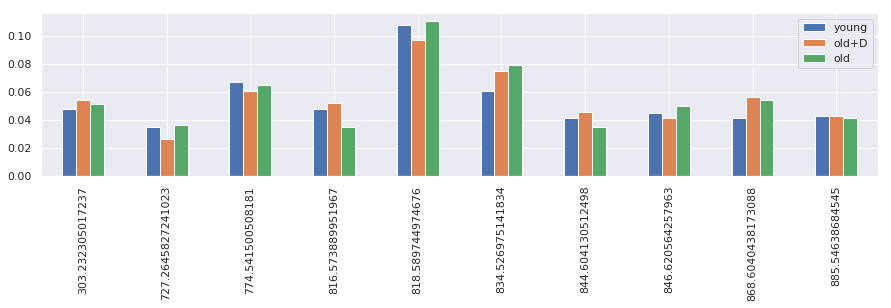

Brain (PFC)


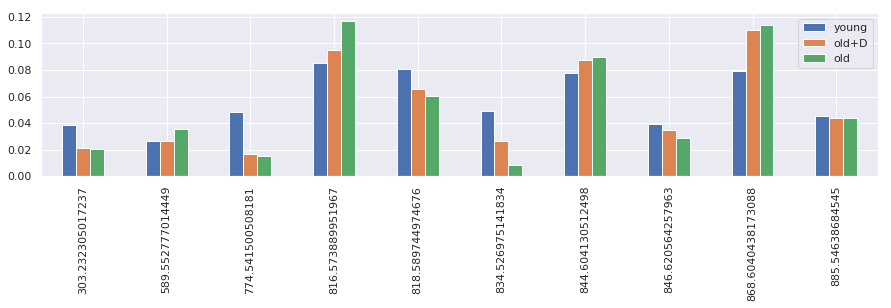

Liver


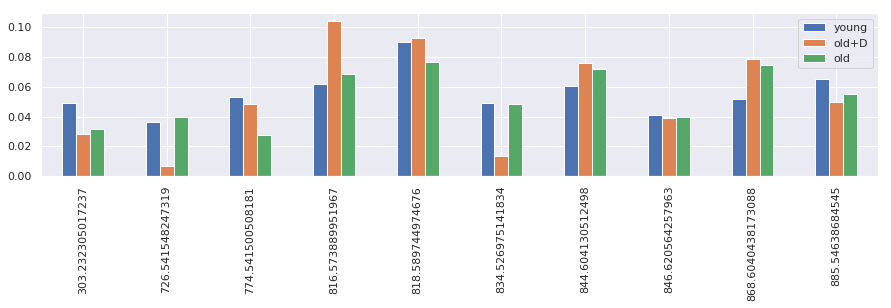

Brain (CB)


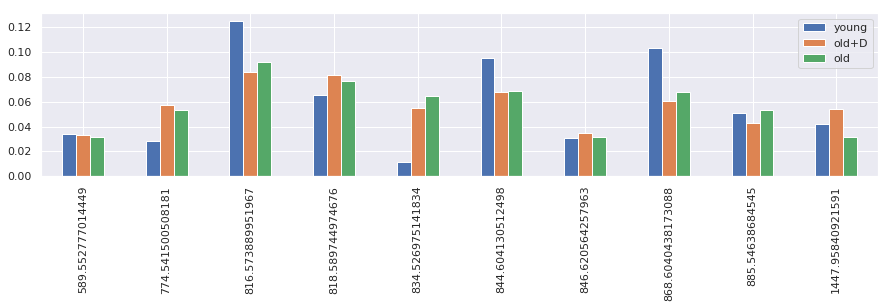

Muscle


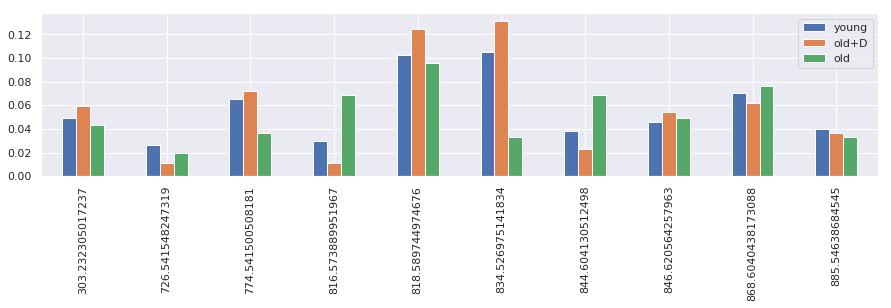

In [177]:
N = 10
for tissue in set(md['Tissue']): # три группы на одном графике по тканям
    vitamin = group_data[tissue]['old']['yes']
    old_control = group_data[tissue]['old']['no']
    young_control = group_data[tissue]['young']['no']
    print(tissue)
    ind_yo = sorted(np.maximum(young_control, old_control).sort_values(ascending=False).head(N).index)
    Tissue_df = pd.DataFrame({'young':young_control, 'old+D':vitamin, 'old':old_control})
    Tissue_df.loc[ind_yo].plot.bar(figsize=(15,3))
    plt.show()

In [36]:
# Посмотрим что там в печени
# print('young')
# group_data['Liver']['young']['no'].plot(figsize=(15,3))
# plt.show()
# print('old with D')
# group_data['Liver']['old']['yes'].plot(figsize=(15,3))
# plt.show()
# print('old')
# group_data['Liver']['old']['no'].plot(figsize=(15,3))
# plt.show()